In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

def add_noise(img, noise_factor=0.3):
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy_img, -1, 1)

class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        # Енкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (3,32,32) -> (32,16,16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (32,16,16) -> (64,8,8)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (64,8,8) -> (128,4,4)
            nn.ReLU()
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (128,4,4) -> (64,8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # (64,8,8) -> (32,16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # (32,16,16) -> (3,32,32)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = CNN_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        
        optimizer.zero_grad()
        outputs = autoencoder(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Files already downloaded and verified
Epoch [1/10], Loss: 0.0193
Epoch [2/10], Loss: 0.0170
Epoch [3/10], Loss: 0.0137
Epoch [4/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0142
Epoch [6/10], Loss: 0.0141
Epoch [7/10], Loss: 0.0135
Epoch [8/10], Loss: 0.0121
Epoch [9/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0116


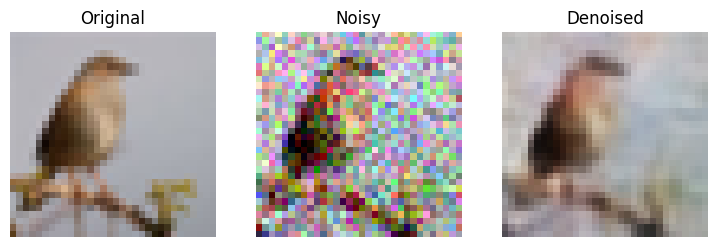

In [26]:
def show_images(original, noisy, clean):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(original[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[0].set_title("Original")

    axes[1].imshow(noisy[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[1].set_title("Noisy")

    axes[2].imshow(clean[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[2].set_title("Denoised")

    for ax in axes:
        ax.axis("off")

    plt.show()

test_img, _ = next(iter(trainloader))
test_img = test_img.to(device)
noisy_img = add_noise(test_img)
output_img = autoencoder(noisy_img).detach()

show_images(test_img, noisy_img, output_img)
